In [22]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pickle


from double_fd_raman import DoubleFDRaman

In [23]:
ATOM_ARGS = {
    "det_zeeman_1": 0.0,
    "det_zeeman_2": 0.0,
    "det_zeeman_3": -2* 0.07,
    "det_zeeman_4": 2 * 0.07,
    "det_centre": -100000
}


env=DoubleFDRaman(
    omega_scaling=3,
    mxstep=4096,
    cg_1= -0.5773502682469887,
    cg_2= -0.2886503889211867,
    cg_3= -0.5773502682469887,
    cg_4= -0.7070865758513278,
    det_centre=ATOM_ARGS["det_centre"],
    delta_1=ATOM_ARGS["det_centre"],
    delta_2=ATOM_ARGS["det_centre"],
    delta_3=ATOM_ARGS["det_centre"]+ATOM_ARGS["det_zeeman_3"],
    delta_4=ATOM_ARGS["det_centre"]+ATOM_ARGS["det_zeeman_4"],
    t_total=0.25
)

In [24]:
def create_flattop_blackman(time_array, laser_amp, ramp_up_time, ramp_down_time):
    """
    Creates a single flattop pulse with a Blackman ramp up and down.
    Args:
        time_array: array of time points over which to calculate the laser amplitude
        laser_amp: amplitude of the laser
        ramp_time: time over which the ramp up and down occur
    Returns:
        laser_array: array of amplitudes
    """
    #assert ramp time is less total time
    if ramp_up_time + ramp_down_time < time_array[-1]:
        AssertionError("Ramp up and down time is greater than total time")

    T = time_array[-1]  # Total duration of the pulse
    
    # Define the Blackman ramp-up and ramp-down function
    def flattop_fct(t, T):
        if t < ramp_up_time:  # Ramp up
            return 0.42 - 0.5 * np.cos(2 * np.pi * t / (2 * ramp_up_time)) + \
                   0.08 * np.cos(4 * np.pi * t / (2 * ramp_up_time))
        elif t > T - ramp_down_time:  # Ramp down
            t_ramp = T - t
            return 0.42 - 0.5 * np.cos(2 * np.pi * t_ramp / (2 * ramp_down_time)) + \
                   0.08 * np.cos(4 * np.pi * t_ramp / (2 * ramp_down_time))
        else:  # Flattop region
            return 1

    # Apply the flattop function to the time array
    laser_array = np.array([laser_amp * flattop_fct(t, T) for t in time_array])

    return laser_array

In [25]:
#generate four blackman pulse with 50 samples each
pulse_1 = 1 * create_flattop_blackman(env.ts_action, 1, 0.075, 0.075) / 0.5773502682469887
pulse_2 = 1 * create_flattop_blackman(env.ts_action, 1, 0.075, 0.075) / 0.2886503889211867
zeros= jnp.zeros((50,))

#concatenate four blackman pulses
action=jnp.concatenate([pulse_1, zeros, pulse_2, zeros])

In [26]:
# Load the pkl file

with open(
        "saved_data/double_fd_raman/78p02fnx/double_fd_raman_78p02fnx_960000.pkl",
        "rb") as f:
    data = pickle.load(f)

real_1, imag_1, real_2, imag_2, _, _ = data

action = jnp.concatenate([real_1, imag_1, real_2, imag_2])


In [27]:
out, _, n_steps = env.test_sim_step(action)

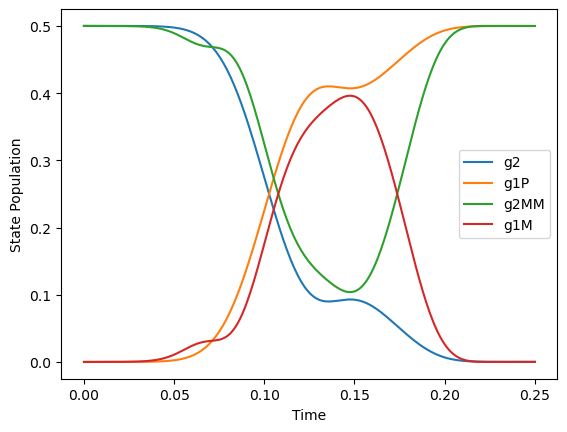

In [28]:
#plot results on single plot
t_plot = jnp.linspace(0, env.ts_action[-1], 250)


plt.xlabel("Time")
plt.ylabel("State Population")
plt.plot(t_plot, jnp.abs(out[:,0])**2, label="g2")
plt.plot(t_plot, jnp.abs(out[:, 1])**2, label="g1P")
plt.plot(t_plot, jnp.abs(out[:, 2])**2, label="g2MM")
plt.plot(t_plot, jnp.abs(out[:, 3])**2, label="g1M")
plt.legend()
plt.show()